In [4]:
import sys, qiskit
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
import numpy as np
import csv
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, random_circuit, metric
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
import pickle
import scipy
from numpy import trace as np_trace
from qiskit.quantum_info import Pauli, Operator
import qiskit.quantum_info as qi

In [24]:
hamiltonian= qiskit.quantum_info.SparsePauliOp(['ZZ', 'IZ', 'ZI'], [-1, -1, -1]).to_matrix() 

def gibbs_state(beta): 
    # Generate the ideal target Gibbs state rho
    rho_G = scipy.linalg.expm(-1 * beta * hamiltonian) / np_trace(scipy.linalg.expm(-1 * beta * hamiltonian))
    
    return rho_G

In [26]:
gibbs_state(0.1)

array([[0.33211997+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.22262668+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.22262668+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.22262668+0.j]])

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
1.0745380149674383e-07
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
1.0745380149674383e-07
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
1.0745380149674383e-07
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
1.0745380149674383e-07
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
1.0745380149674383e-07
1.0745380149674383e-07
1.0745380149674383e-07
1.0745380149674383e-07
1.0745380149674383e-07
1.0745380149674383e-07


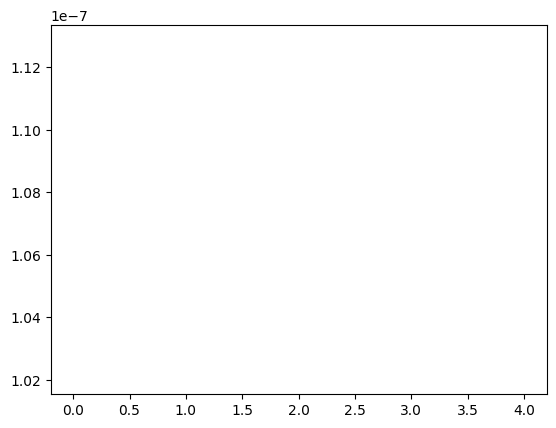

In [23]:
# # Now you reconstruct the compiler
betas = np.linspace(0,1,5)
#load best circuit
loaded_qc = ansatz.g2gn(2,1)#utilities.load_circuit('n=2,d=4,n_circuit=4,n_gen=8/best_circuit')

qsp_list = []
#get theta values
for beta in betas:
    qc_time = np.asarray(gibbs_state(beta))
    qsp = QuantumStatePreparation(
        u=loaded_qc,
        target_state=qc_time
    ).fit(num_steps=100)
    print(qi.Statevector.from_instruction(qsp.vdagger))
    print(qsp.compiler.metrics['loss_fubini_study'][-1])
    qsp_list.append(qsp)

for i in range(len(qsp_list)):
    print(qsp_list[i].compiler.metrics['loss_fubini_study'][-1])
    plt.plot(i,qsp_list[i].compiler.metrics['loss_fubini_study'][-1],label='theory')

# Define the file name
csv_file = 'gibbs_thetass.csv'

# Extract data from each QuantumStatePreparation object
data = []
for qsp in qsp_list:
    # Extract relevant data, such as theta values
    theta_values = qsp.thetas 
    data.append(theta_values)

# Write the data to a CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

In [42]:
# Define the file name
csv_file = 'gibbs_thetass.csv'

# Create an empty list to store loaded data
thetass = []

# Read data from the CSV file
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    # Skip header if present
    # next(reader)  # Uncomment this line if your CSV file has a header row
    # Read rows and append to the list
    for row in reader:
        # Assuming theta values are stored as floats in the CSV file
        theta_values = [float(value) for value in row]
        thetass.append(theta_values)

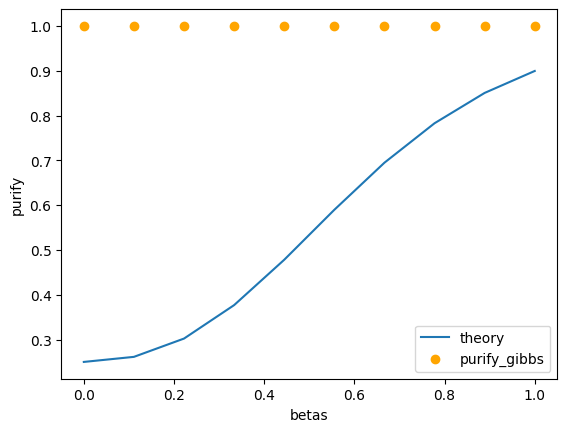

In [43]:
### Purify test
betas_theo = np.linspace(0,1,10)
fidelity_gibbs = []
purify_gibbs = []
purify_theo = []
# for GA
for i, beta in enumerate(betas):
    qc_thermal = np.conjugate(gibbs_state(beta)).T
    qc_ga = loaded_qc
    parameters_ga = np.expand_dims(thetass[i], axis=0)
    # purify, fidelity = metric.gibbs_metrics(u=qc_ga,vdagger=qc_thermal,thetass=parameters_ga) 
    # fidelity_gibbs.append(fidelity)
    # purify_gibbs.append(purify)

    qc_p = qc_ga.assign_parameters(thetass[i])
    rho_ga = qi.DensityMatrix(qc_p)
    purify_gibbs.append(np.trace(rho_ga.data**2))
    
    purify_theo.append(np.trace(qc_thermal**2))

#plot
#plt.scatter(ps, fidelity_gibbs, label='fidelity_gibbs', marker='o', color='blue')
plt.plot(betas_theo,purify_theo,label='theory')
plt.scatter(ps, purify_gibbs, label='purify_gibbs', marker='o', color='orange')
plt.xlabel('betas')
plt.ylabel('purify')
plt.legend()
plt.savefig('gibbs.png')
plt.show()
plt.close()